# Recipes Bot

# BLOC 1 : Détection d'image






Imports

In [1]:
import cv2
import torch
import torchvision.transforms as transforms
from transformers import AutoModelForImageClassification
from PIL import Image

Liste des labels en français

In [2]:
FR_LABELS = ['pomme', 'banane', 'betterave', 'poivron', 'chou', 'piment', 'carotte', 'chou-fleur', 'piment', 'maïs', 'concombre', 'aubergine' , 'ail', 'gingembre', 'raisins', 'jalepeno', 'kiwi', 'citron', 'laitue', 'mangue', 'oignon', 'orange', 'paprika', 'poire', ' pois', 'ananas', 'grenade', 'pomme de terre', 'radis', 'fèves de soja', 'épinards', 'maïs doux', 'patate douce', 'tomate', 'navet', 'pastèque']

Modèle : https://huggingface.co/jazzmacedo/fruits-and-vegetables-detector-36 --> Modèle pré-entraîné et fine-tuné sur ResNet50 de Microsoft avec le dataset suivant : https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition.

In [3]:
def run_detection_model(image_path):
  # Load the saved model and tokenizer
  model = AutoModelForImageClassification.from_pretrained("jazzmacedo/fruits-and-vegetables-detector-36")

  # Get the list of labels from the model's configuration
  labels = list(model.config.id2label.values())

  # Define the preprocessing transformation
  preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  pil_image = Image.fromarray(image)  # Convert NumPy array to PIL image
  input_tensor = preprocess(pil_image).unsqueeze(0)

  # Run the image through the model
  outputs = model(input_tensor)

  # Get the predicted label index
  predicted_idx = torch.argmax(outputs.logits, dim=1).item()

  # Get the predicted label text
  #predicted_label = labels[predicted_idx]
  predicted_label = FR_LABELS[predicted_idx]
  # Print the predicted label
  return predicted_label

In [4]:
#Utilisation :
#run_detection_model('images/pear.jpg')

#Bloc 2 : Génération de texte

In [5]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

##1 - Téléchargement du dataset "Fruits 360"

In [7]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset

fatal: destination path 'Fruit-Images-Dataset' already exists and is not an empty directory.


In [8]:
%cd "./Fruit-Images-Dataset"
%ls

/content/Fruit-Images-Dataset
LICENSE  papers/  readme.md  src/  Test/  test-multiple_fruits/  Training/


In [9]:
train_dir = "./Training/"
test_dir = "./Test/"

In [10]:
images_train = []
images_test = []
labels_train = []
labels_test = []

for label_train in os.listdir(train_dir):
  label_dir = train_dir+label_train+"/"
  for image_file in os.listdir(label_dir):
    labels_train.append(label_train)
    images_train.append(np.array(Image.open(label_dir+image_file).convert("RGB")))

for label_test in os.listdir(test_dir):
  label_dir = test_dir+label_test+"/"
  for image_file in os.listdir(label_dir):
    labels_test.append(label_test)
    images_test.append(np.array(Image.open(label_dir+image_file).convert("RGB")))

In [11]:
print("Train / Taille dataset d'images: ", np.array(images_train).shape)
print("Train / Taille labels: ", len(labels_train), "\n")
print("Test / Taille dataset d'images: ", np.array(images_test).shape)
print("Test / Taille labels: ", len(labels_test))

Train / Taille dataset d'images:  (67692, 100, 100, 3)
Train / Taille labels:  67692 

Test / Taille dataset d'images:  (22688, 100, 100, 3)
Test / Taille labels:  22688


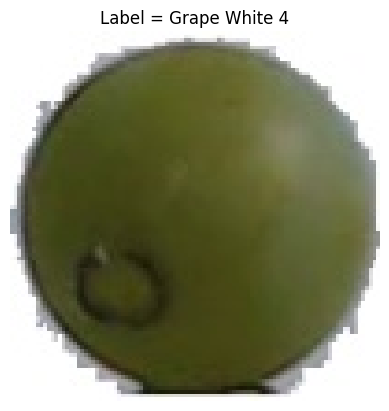

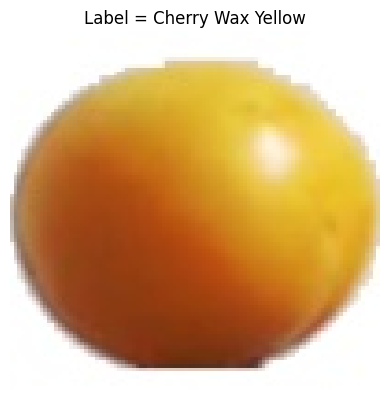

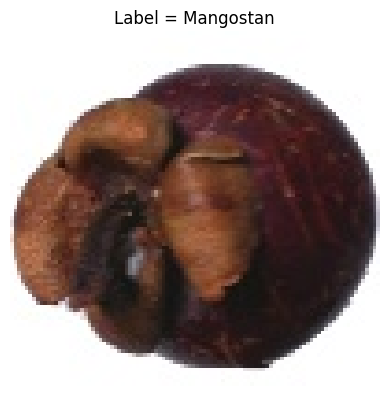

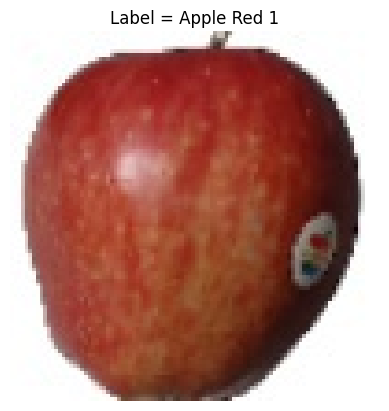

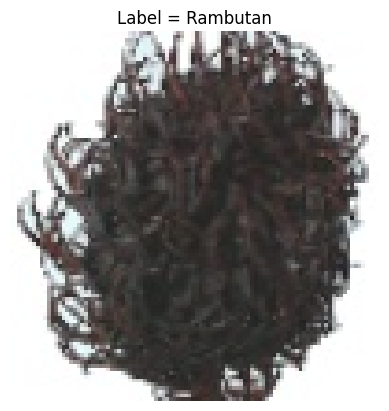

In [12]:
# Affichage 5 images random du dataset de train avec leurs labels
for i in range(5):
  index = np.random.randint(low=0, high=len(labels_train))
  image = images_train[index]
  label = labels_train[index]
  plt.title("Label = " + label)
  plt.imshow(image)
  plt.axis("off")
  plt.show()

## 2 - Modèle LLM

In [13]:
!pip install git+https://github.com/bofenghuang/vigogne

  Cloning https://github.com/bofenghuang/vigogne to /tmp/pip-req-build-k57kbl91
  Running command git clone --filter=blob:none --quiet https://github.com/bofenghuang/vigogne /tmp/pip-req-build-k57kbl91
  Resolved https://github.com/bofenghuang/vigogne to commit 67ea8a2a06f1ddd5652da274c9d537e2223468bc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-install-kql37yru/accelerate_f60273a924cb4fea8ef394bdaceb09ec
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-install-kql37yru/accelerate_f60273a924cb4fea8ef394bdaceb09ec
  Resolved https://github.com/huggingface/accelerate.git to commit 244122c736141b164242084c659b6dafa4208fea
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (p

In [14]:
from typing import Dict, List, Optional
from transformers import  AutoModelForCausalLM, AutoTokenizer, GenerationConfig, TextStreamer

In [15]:
!pip install sentencepiece

In [16]:
model_name_or_path = "bofenghuang/vigostral-7b-chat"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="right", use_fast=False)
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto").to(device)
streamer = TextStreamer(tokenizer, timeout=10.0, skip_prompt=True, skip_special_tokens=True)

def chat(
    query: str,
    history: Optional[List[Dict]] = None,
    temperature: float = 0.7,
    top_p: float = 1.0,
    top_k: float = 0,
    repetition_penalty: float = 1.1,
    max_new_tokens: int = 1024,
    **kwargs,
):
    if history is None:
        history = []

    history.append({"role": "user", "content": query})

    input_ids = tokenizer.apply_chat_template(history, return_tensors="pt").to(model.device)
    input_length = input_ids.shape[1]

    generated_outputs = model.generate(
        input_ids=input_ids,
        generation_config=GenerationConfig(
            temperature=temperature,
            do_sample=temperature > 0.0,
            top_p=top_p,
            top_k=top_k,
            repetition_penalty=repetition_penalty,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            **kwargs,
        ),
        streamer=streamer,
        return_dict_in_generate=True,
    )

    generated_tokens = generated_outputs.sequences[0, input_length:]
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    history.append({"role": "assistant", "content": generated_text})

    return generated_text, history


# 1st round
response, history = chat("Un escargot parcourt 100 mètres en 5 heures. Quelle est sa vitesse ?", history=None)

# 2nd round
response, history = chat("Quand il peut dépasser le lapin ?", history=history)

# 3rd round
response, history = chat("Écris une histoire imaginative qui met en scène une compétition de course entre un escargot et un lapin.", history=history)

'\nmodel_name_or_path = "bofenghuang/vigostral-7b-chat"\ntokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="right", use_fast=False)\nmodel = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto").to(device)\nstreamer = TextStreamer(tokenizer, timeout=10.0, skip_prompt=True, skip_special_tokens=True)\n\ndef chat(\n    query: str,\n    history: Optional[List[Dict]] = None,\n    temperature: float = 0.7,\n    top_p: float = 1.0,\n    top_k: float = 0,\n    repetition_penalty: float = 1.1,\n    max_new_tokens: int = 1024,\n    **kwargs,\n):\n    if history is None:\n        history = []\n\n    history.append({"role": "user", "content": query})\n\n    input_ids = tokenizer.apply_chat_template(history, return_tensors="pt").to(model.device)\n    input_length = input_ids.shape[1]\n\n    generated_outputs = model.generate(\n        input_ids=input_ids,\n        generation_config=GenerationConfig(\n            temperature=t

Ancienne version avec Vigogne :

In [17]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from vigogne.preprocess import generate_instruct_prompt
import sentencepiece

In [18]:
base_model_name_or_path = "bofenghuang/vigogne-2-13b-instruct" #bofenghuang/vigogne-7b-instruct

tokenizer = AutoTokenizer.from_pretrained(base_model_name_or_path, padding_side="right", use_fast=False)
# tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    base_model_name_or_path,
    torch_dtype=torch.float16,
    device_map="auto",
    # load_in_8bit=True,
    # trust_remote_code=True,
    low_cpu_mem_usage=True,
)

# lora_model_name_or_path = ""
# model = PeftModel.from_pretrained(model, lora_model_name_or_path)

model.eval()

if torch.__version__ >= "2":
    model = torch.compile(model)

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

model-00001-of-00014.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00002-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00003-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00004-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00005-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00006-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00007-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00008-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00009-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00010-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00011-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00012-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00013-of-00014.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

model-00014-of-00014.safetensors:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [19]:
def instruct(
    user_query ,
    temperature=0.1,
    max_new_tokens=512,
    **kwargs,
):
    prompt = generate_instruct_prompt(user_query)
    input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].to(model.device)
    input_length = input_ids.shape[1]

    generated_outputs = model.generate(
        input_ids=input_ids,
        generation_config=GenerationConfig(
            temperature=temperature,
            do_sample=temperature > 0.0,
            max_new_tokens=max_new_tokens,
            **kwargs,
          ),
        return_dict_in_generate=True,
    )
    generated_tokens = generated_outputs.sequences[0, input_length:]
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    return generated_text

In [20]:
def give_n_recipes(list_fruits, n_recipes=2):
  prompt = "Je souhaite cuisiner un plat et je souhaite avoir une recette détaillé. Donne une liste de "+ str(n_recipes) +" recettes connues étape par étape que je peux faire avec : "
  for f in list_fruits:
    prompt += f + " ; "
  print(chat(prompt)) #print(instruct(prompt))

## 3 - Demande utilisateur et saisie des ingrédients

### A - Saisie des fruits et légumes

In [21]:
def ask_user_fruits_and_vegetables():
  list_fruits = []

  print("Donnez la liste des fruits et des légumes que vous possèdez")
  print("Assurez-vous que le fruit existe et que son ortographe soit correct")
  print("Lorsque vous avez fini, saissisez \"stop\" \n")

  while True:
    list_fruits = []
    choice = input("Saisir un fruit ou un légume (saisir stop pour arrêter) : ")
    while choice != "stop":
      list_fruits.append((choice.strip().lower().replace(" ", "")))
      choice = input("Saisir un fruit ou un légume (saisir stop pour arrêter) : ")
    print("Validez-vous cette liste ? :")
    print(list_fruits)
    confirm = input("Saisir 1 pour confirmer, 2 pour refaire la liste : ")
    while confirm != "1" and confirm != "2":
      confirm = input("Mauvaise saisie, saisir 1 pour confirmer, 2 pour refaire la liste : ")
    if confirm == "1": break
  return list_fruits

In [22]:
listf = ask_user_fruits_and_vegetables()
print(listf)

Donnez la liste des fruits et des légumes que vous possèdez
Assurez-vous que le fruit existe et que son ortographe soit correct
Lorsque vous avez fini, saissisez "stop" 

Saisir un fruit ou un légume (saisir stop pour arrêter) : stop
Validez-vous cette liste ? :
[]
Saisir 1 pour confirmer, 2 pour refaire la liste : 1
[]


### C - Demande utilisateur

In [23]:
def ask_user():
  print("Bonjour, bienvenue sur Recipes Bot !!")

  # Liste fruits et légumes
  list_fruits = []
  print("Comment souhaitez-vous saisir la liste des fruits et des ingrédients ?")
  print("1 - Avec une photo \n2 - Par saisie de texte")
  choice = input("Saisissez le numéro de votre choix : ")
  while choice != "1" and choice != "2":
    choice = input("Mauvaise saisie! Tapez un numéro entre 1 et 2 selon votre choix : ")
  if choice == "1":
    # detection fruits dans photo
    #pass
    list_fruits = run_detection_model('/content/Fruit-Images-Dataset/Training/Banana/104_100.jpg')


  elif choice == "2":
    print("")
    list_fruits = ask_user_fruits_and_vegetables()
  print("\nVoici la liste des fruits et légumes : ")
  print(list_fruits, "\n")

  # Génération des 10 recettes
  give_n_recipes(list_fruits, n_recipes=2)

In [26]:
ask_user()

Bonjour, bienvenue sur Recipes Bot !!
Comment souhaitez-vous saisir la liste des fruits et des ingrédients ?
1 - Avec une photo 
2 - Par saisie de texte
Saisissez le numéro de votre choix : 1

Voici la liste des fruits et légumes : 
banane 



KeyboardInterrupt: ignored